# Setup

### Find paths

In [9]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/benchmark_process_packet.exe"
exec_path

'/home/bm611/ebsl/benchmark_process_packet.exe'

### Run benchmark function

In [101]:
import numpy as np
import json

def run(scheduler,domains=-1,spawners=-1):
    results = [] 
    
    for i in range(0,10):
        cmd = (
            "perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary " +
            exec_path + " -scheduler " + scheduler + " -num-of-domains " + str(domains) + 
            " -num-of-spawners " + str(spawners) + " -items-total " + str(tasks)) + " > /dev/null"
        print(cmd)
        output = !$cmd
        exploded = [v.split(",") for v in output]

        result = {}
        result[exploded[3][6]] = float(exploded[3][5])
        result[exploded[4][6]] = float(exploded[4][5])
        results.append(result)
        
    return results

In [102]:
def find_percentile(array, percentile):
    assert (0 < percentile and percentile < 1)
    
    total = np.sum(array)
    
    percentile_boundary = percentile * total 
    current_total = 0
    for i in range(0,len(array)):
        current_total += array[i]
        if current_total > percentile_boundary:
            return i
    
    return "reached the end before finding percentile boundary"


def transform(parsed):
    time = [] 
    latency_half = []
    latency_threenine = []
    waited_for_space_on_enque = [] 
    latency = []
    latency_q10 = []
    latency_q25 = []
    latency_q50 = []
    latency_q99 = []
    latency_q999 = [] 
    latency_q9999 = []
    latency_q99999 = []

    for row in parsed['data']:
        if row['iteration'] == 1:
            continue

        time.append(row['time'])
        latency_half.append(latency_undo_exp(row['latency_median']))
        latency_threenine.append(latency_undo_exp(row['latency_three_nine']))
        waited_for_space_on_enque.append(row['waited-for-space-on-enque'])
        latency.append(row['latency'])
        
        latency_q50.append(latency_undo_exp(find_percentile(row['latency'], 0.5)))
        latency_q99.append(latency_undo_exp(find_percentile(row['latency'], 0.99)))
        latency_q999.append(latency_undo_exp(find_percentile(row['latency'], 0.999)))
        latency_q9999.append(latency_undo_exp(find_percentile(row['latency'], 0.9999)))
        latency_q99999.append(latency_undo_exp(find_percentile(row['latency'], 0.99999)))
                

    return {'time':time, 
            'waited_for_space_on_enque':waited_for_space_on_enque,
            'latency':latency,
            'latency_q50':latency_q50,
            'latency_q99':latency_q99,
            'latency_q999':latency_q999,
            'latency_q9999':latency_q9999,
            'latency_q99999':latency_q99999,
            'latency_half':latency_half,
            'median_latency_threenine':latency_threenine,
           }

In [103]:
def to_median_and_errs(array):
    median = np.median(array,axis=1)
    lower_err = median - np.quantile(array, 0.25,axis=1)
    upper_err = np.quantile(array, 0.75,axis=1) - median
    return {'median': median, 'lower_err': lower_err, 'upper_err': upper_err}
    
def add_metrics(data):
    data['ins_per_cycle-processed'] = to_median_and_errs(data['ins_per_cycle'])
    data['stalled_cycles_per_ins-processed'] = to_median_and_errs(data['stalled_cycles_per_ins'])
    

### Find percentiles function

### Plotting

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

# Experiment 1: simple workload, skewed

## Data collection

In [104]:
param_space = range(5,120,5)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=i, spawners=1))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=i, spawners=1))
    
x = list(param_space)

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -schedule

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 25 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 25 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 5 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 20 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 40 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 60 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 80 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sche

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 95 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 95 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 100 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -sc

perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null
perf stat -x , -e cycles,instructions,stalled-cycles-backend -D 100 --no-csv-summary /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 115 -num-of-spawners 1 -items-total 50000 > /dev/null


In [105]:
def transform(data):    
    ins_per_cycle = [] 
    stalled_cycles_per_ins = []
    for row in data:
        
        ins_per_cycle_single = []
        stalled_cycles_per_ins_single = []
        for v in row:
            ins_per_cycle_single.append(v['insn per cycle'])
            stalled_cycles_per_ins_single.append(v['stalled cycles per insn'])
            
        ins_per_cycle.append(ins_per_cycle_single)
        stalled_cycles_per_ins.append(stalled_cycles_per_ins_single)

    return {'ins_per_cycle': ins_per_cycle, 
            'stalled_cycles_per_ins': stalled_cycles_per_ins}

In [106]:
fifo_transformed = transform(fifo)
lifo_transformed = transform(lifo)

In [107]:
add_metrics(fifo_transformed)
add_metrics(lifo_transformed)

In [108]:
fifo_transformed

{'ins_per_cycle': [[1.59, 1.6, 1.61, 1.59, 1.58, 1.59, 1.61, 1.62, 1.6, 1.62],
  [0.92, 0.92, 0.92, 0.92, 0.9, 0.92, 0.92, 0.93, 0.93, 0.93],
  [0.67, 0.65, 0.66, 0.66, 0.68, 0.67, 0.66, 0.67, 0.66, 0.66],
  [0.57, 0.55, 0.57, 0.56, 0.57, 0.56, 0.57, 0.56, 0.56, 0.58],
  [0.51, 0.51, 0.52, 0.51, 0.52, 0.5, 0.51, 0.52, 0.52, 0.51],
  [0.48, 0.47, 0.47, 0.47, 0.46, 0.47, 0.45, 0.47, 0.47, 0.47],
  [0.45, 0.45, 0.44, 0.44, 0.44, 0.45, 0.44, 0.45, 0.43, 0.44],
  [0.43, 0.43, 0.44, 0.43, 0.42, 0.43, 0.43, 0.42, 0.43, 0.43],
  [0.42, 0.41, 0.41, 0.42, 0.41, 0.41, 0.41, 0.4, 0.41, 0.41],
  [0.4, 0.39, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
  [0.39, 0.38, 0.37, 0.38, 0.38, 0.38, 0.38, 0.37, 0.38, 0.38],
  [0.38, 0.38, 0.38, 0.39, 0.38, 0.38, 0.37, 0.38, 0.38, 0.38],
  [0.37, 0.38, 0.38, 0.38, 0.38, 0.38, 0.37, 0.38, 0.34, 0.38],
  [0.35, 0.36, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35],
  [0.33, 0.33, 0.33, 0.33, 0.34, 0.33, 0.34, 0.33, 0.33, 0.32],
  [0.32, 0.32, 0.32, 0.32, 0.32, 0.32

In [109]:
run_name = "counters"

In [110]:
import pickle


with open('packet_fifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(fifo, handle)
    

with open('packet_lifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(lifo, handle)


## Analysis

### Exec time vs number of domains

In [111]:
def to_series(data, label):
    return [v[label]["median"] for v in data]

In [112]:
def plot(x, data, key, name):
    data = data[key]
    y = data["median"]
    lower_errbar = data["lower_err"] 
    upper_errbar = data["upper_err"] 
    
    return ax.errorbar(x, y, [lower_errbar, upper_errbar], label=name)
    

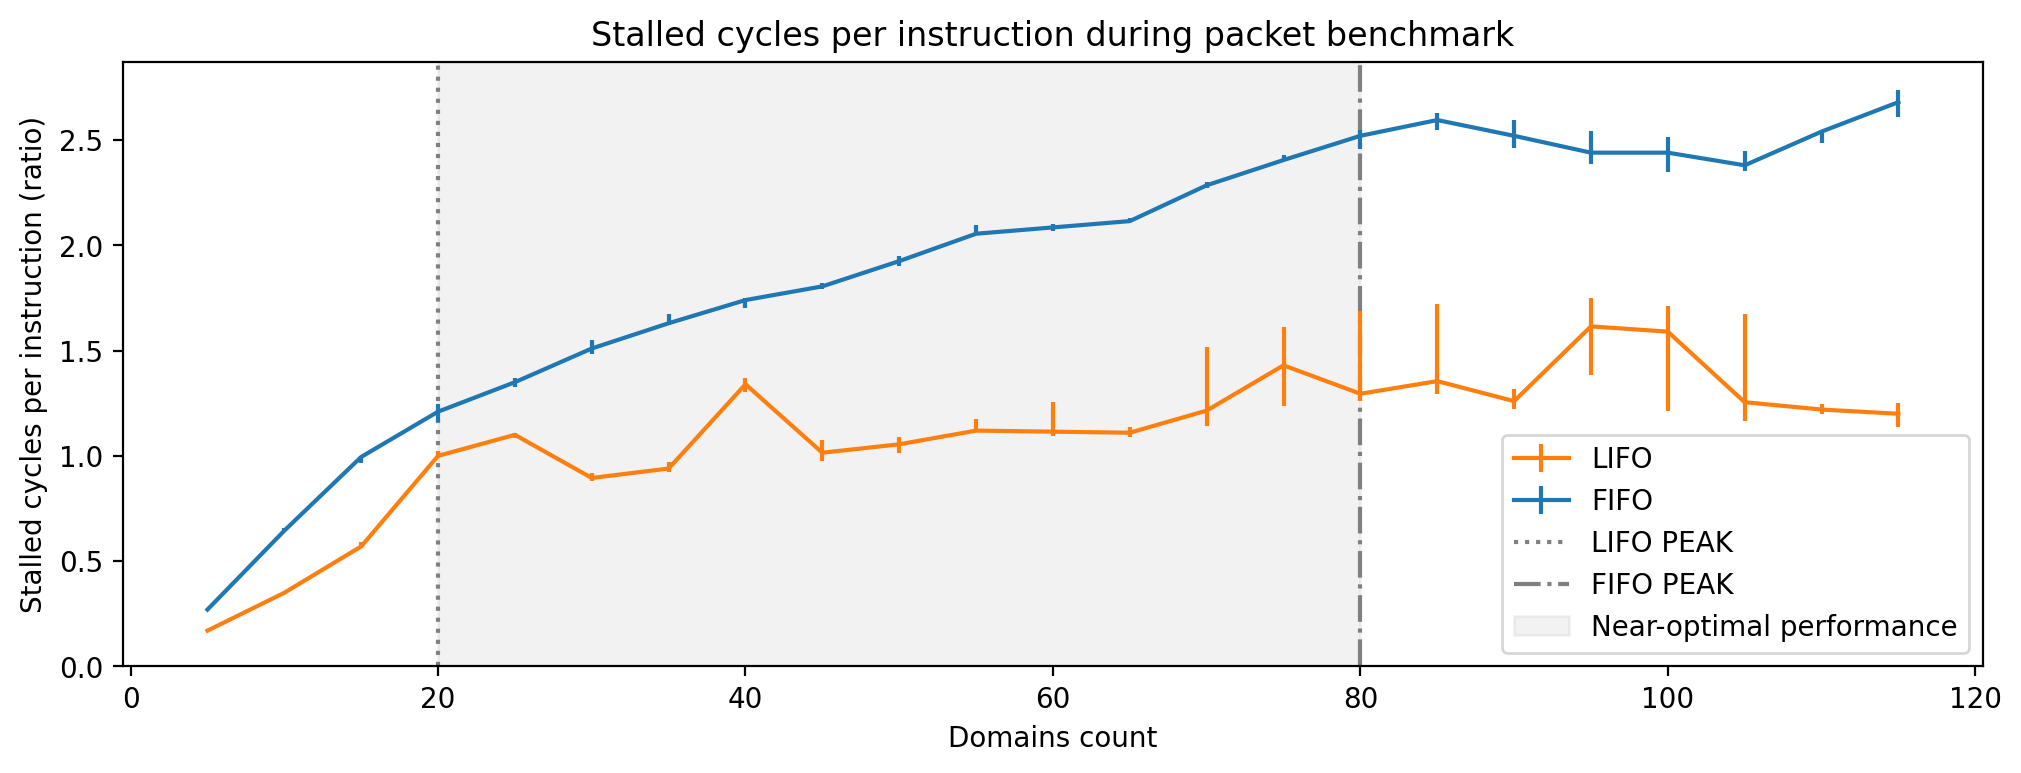

In [120]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

size = 1

fig, axes = plt.subplots(size, 1, sharex=True)
fig.set_size_inches(12, 4 * size)


ax = axes

area = ax.axvspan(20, 80, color='gray', alpha=0.1, label="Near-optimal performance")
lifo_peak = ax.axvline(x=20, color="grey", label="LIFO PEAK", linestyle=":")
fifo_peak = ax.axvline(x=80, color="grey", label="FIFO PEAK", linestyle="-.")

line_lifo = plot(x, fifo_transformed, "stalled_cycles_per_ins-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "stalled_cycles_per_ins-processed", 'LIFO')

ax.legend(handles=[line_fifo, line_lifo, lifo_peak, fifo_peak, area])

#ax.set_yscale("log")
ax.set_ylim(ymin=0)
ax.set_title("Stalled cycles per instruction during packet benchmark")
ax.set_ylabel('Stalled cycles per instruction (ratio)')
ax.set_xlabel('Domains count')


plt.savefig("packet-basic-" + run_name + ".png", dpi=200)